# Data Assimilation

An interesting introduction:
https://www.youtube.com/watch?v=XwDu5MpeCFk

To make things more interesting, let's focus on a nonlinear PDE:

### Burger Equation

$$ \frac{\partial u}{\partial t} + a u \frac{\partial u}{\partial x}=0 $$

In [11]:
import numpy as np
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt
%matplotlib inline

def gaussian(x, mu, sig):
    c=np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))
    c=c/np.max(c)
    return c

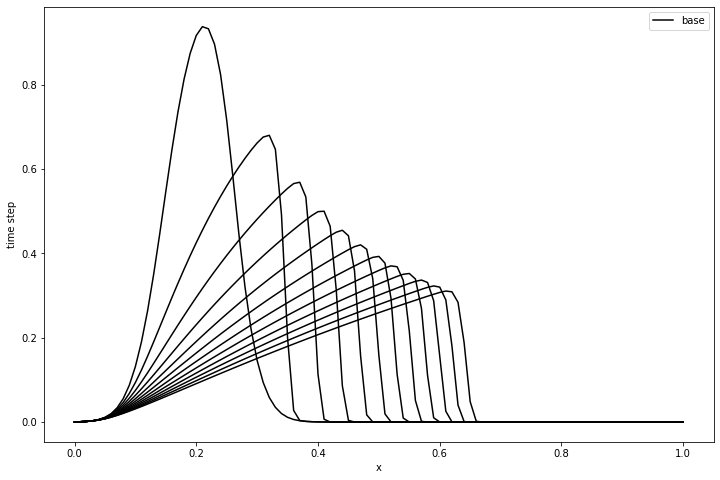

In [12]:
K =0.02
J =101
deltax = 1/J
deltat= 0.007
x=np.linspace(0,1,J)
U=1
a=1
nt=96*2

u_init=gaussian(x,0.2,0.05)
u=u_init.copy()

fig=plt.figure(figsize=(12,8))
ax = fig.gca()
# ax.view_init(elev=30, azim=30)

# ax.plot(x,i+np.zeros_like(x),u,color='black',label='base')

for n in range(0,nt):
#     print('CFL=',np.max(deltat*u/deltax))
    u[0]=u[J-1]
    for i in range(1,J-1):
#        u[i]=u[i]-deltat/deltax*(np.max(u[i],0)*(u[i]-u[i-1])+np.min(u[i],0)*(u[i+1]-u[i])) # non-conservative upwind
        u[i]=u[i]-a*deltat/deltax/2*(u[i]**2-u[i-1]**2)
    if n%16==0:
        ax.plot(x,u,color='black')
    
ax.set_xlabel('x')
ax.set_ylabel('time step')
ax.legend(['base'])
plt.show()

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: overflow encountered in double_scalars
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in double_scalars


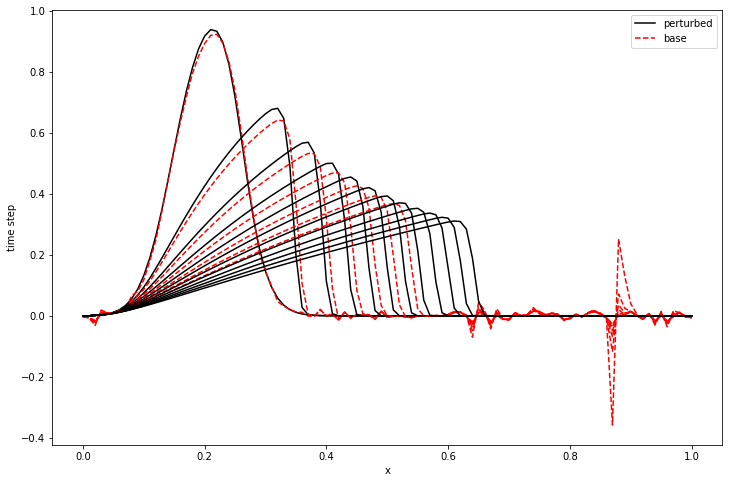

In [13]:
# sensitivity to the intitial condition and system parameter
error=1e-2

u0=u_init.copy()
a0=1
u=u_init.copy()+np.random.randn(u.shape[0])*error
a=1.1

# plt.plot(x,u0)
# plt.plot(x,u)

n=0
fig=plt.figure(figsize=(12,8))
ax = fig.gca()
# ax.view_init(elev=0, azim=90)

# ax.plot(x,n+np.zeros_like(x),u,color='red',label='perturbed')
# ax.plot(x,n+np.zeros_like(x),u0,color='black',label='base')

for n in range(0,nt):
#     print('CFL=',np.max(deltat*u/deltax))
    u[0]=u[J-2]
    u[1]=u[J-1]
    u0[0]=u0[J-2]
    u0[1]=u0[J-1]
    for i in range(1,J-1):
#        u[i]=u[i]-deltat/deltax*(np.max(u[i],0)*(u[i]-u[i-1])+np.min(u[i],0)*(u[i+1]-u[i])) # non-conservative upwind
        u[i] =u[i] -a*deltat/deltax/2*(u[i]**2 -u[i-1]**2 )
        u0[i]=u0[i]-a0*deltat/deltax/2*(u0[i]**2-u0[i-1]**2)
    if n%16==0:
        ax.plot(x,u0,color='black')
        ax.plot(x,u,'--',color='red')
    
ax.set_xlabel('x')
ax.set_ylabel('time step')
ax.legend(['perturbed','base'])
plt.show()

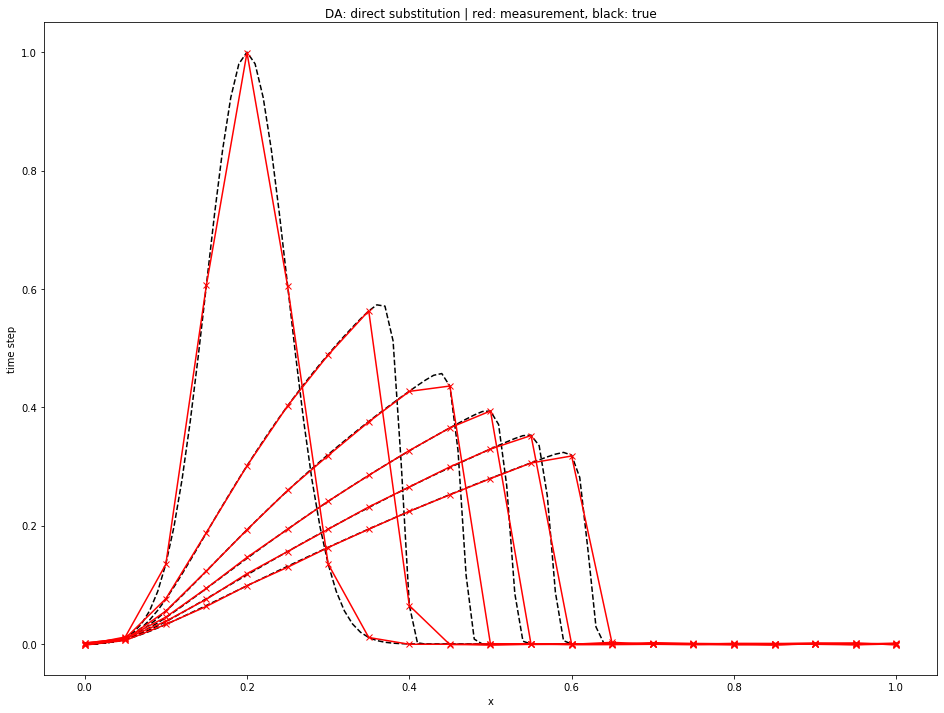

In [14]:
# Prepare true simulation and save the measurement data

error=1e-3

u0=u_init.copy()       # true state
a=1

n=0
fig=plt.figure(figsize=(16,12))
ax = fig.gca()

m_steps=32   # measurement at every xxx steps
m_dist=5
u_m=np.zeros((int(u.shape[0]/m_dist+1),int(nt/m_steps)))
u_t=np.zeros((int(u.shape[0]),nt))

for n in range(0,nt):
#     print('CFL=',np.max(deltat*u/deltax))
    u0[0]=u0[J-2]
    u0[1]=u0[J-1]
    
    # assimilation step
    if n%m_steps==0:
        measurement=u0[::m_dist]+np.random.randn(u_m.shape[0])*error
        u_m[:,int(n/m_steps)]=measurement
        ax.plot(x,u0,'--',color='black')
    
    # move forward
    for i in range(1,J-1):
        u0[i]=u0[i]-a*deltat/deltax/2*(u0[i]**2-u0[i-1]**2)
    
    u_t[:,n]=u0

# save the data

time=np.arange(0,nt,m_steps)*deltat 
data_to_save=np.concatenate((time[:,np.newaxis],u_m.T),axis=1)
np.savetxt('./ADSdata.dat',data_to_save,delimiter='\t')


for i in range(u_m.shape[1]):
    ax.plot(x[::m_dist],u_m[:,i],'x-',color='red')
    
ax.set_xlabel('x')
ax.set_ylabel('time step')
ax.set_title('DA: direct substitution | red: measurement, black: true')
# ax.legend(['perturbed','base'])
plt.show()



## direct substitution
This is a naive correction: when a new data point is obtained, the model state is quickly replaced by the data.

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in double_scalars
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


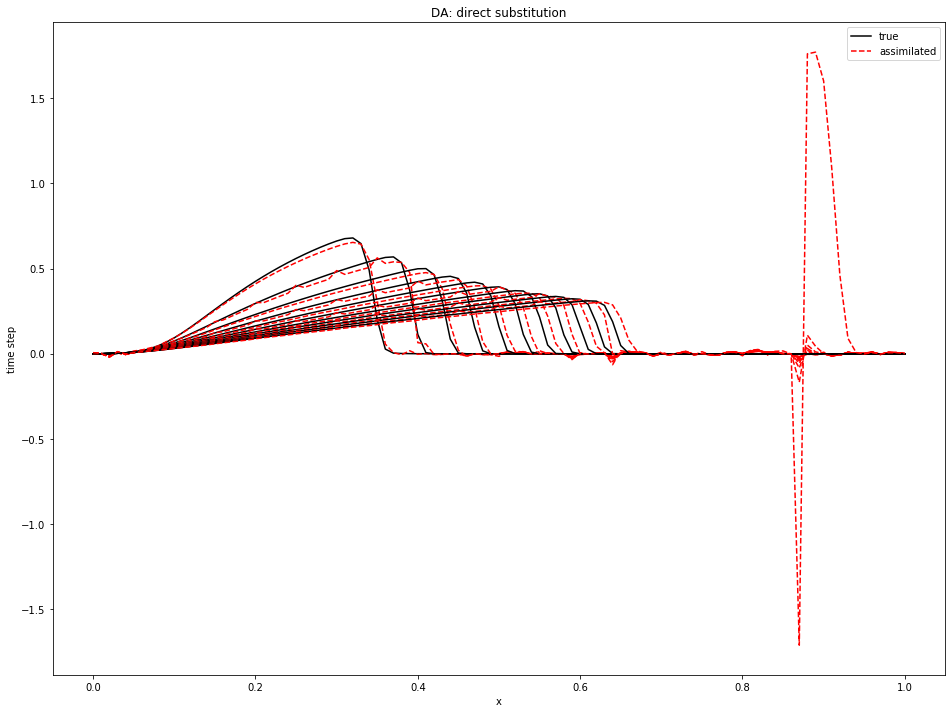

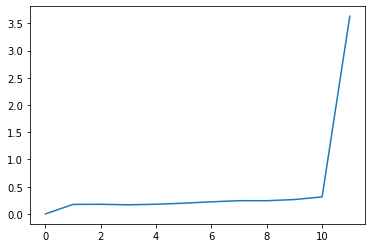

In [15]:
error=1e-2
u=u_init.copy()+np.random.randn(u.shape[0])*error

n=0
fig=plt.figure(figsize=(16,12))
ax = fig.gca()
a=1.1

ass_int=m_steps   # assimilate every xxx steps
n_out=16
err_s=np.zeros(int(nt/n_out))

for n in range(1,nt):
    u[0]=u[J-2]
    u[1]=u[J-1]
    for i in range(1,J-1):
        u[i] =u[i] -a*deltat/deltax/2*(u[i]**2 -u[i-1]**2) 
                                       
    # assimilation step
    if n%ass_int==0:   
        u[::m_dist]=u_m[:,int(n/m_steps)]        # direct substitution
     
    # plot
    if n%n_out==0:
        ax.plot(x,u_t[:,n],color='black')
        ax.plot(x,u,'--',color='red')
        err_s[int(n/n_out)]=np.linalg.norm(u_t[:,n]-u)
    
ax.set_xlabel('x')
ax.set_ylabel('time step')
ax.set_title('DA: direct substitution')
ax.legend(['true','assimilated'])
plt.show()

plt.plot(err_s)
plt.show()


## particle filter:
Particle filters or Sequential Monte Carlo (SMC) methods are a set of Monte Carlo algorithms used to solve filtering problems arising in signal processing and Bayesian statistical inference.

Particle filters implement the prediction-updating updates in an approximate manner. The samples from the distribution are represented by a set of particles; each particle has a likelihood weight assigned to it that represents the probability of that particle being sampled from the probability density function. 

Weight disparity leading to weight collapse is a common issue encountered in these filtering algorithms; however it can be mitigated by including a resampling step before the weights become too uneven. Several adaptive resampling criteria can be used, including the variance of the weights and the relative entropy with respect to the uniform distribution. In the resampling step, the particles with negligible weights are replaced by new particles in the proximity of the particles with higher weights.

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: overflow encountered in double_scalars
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars


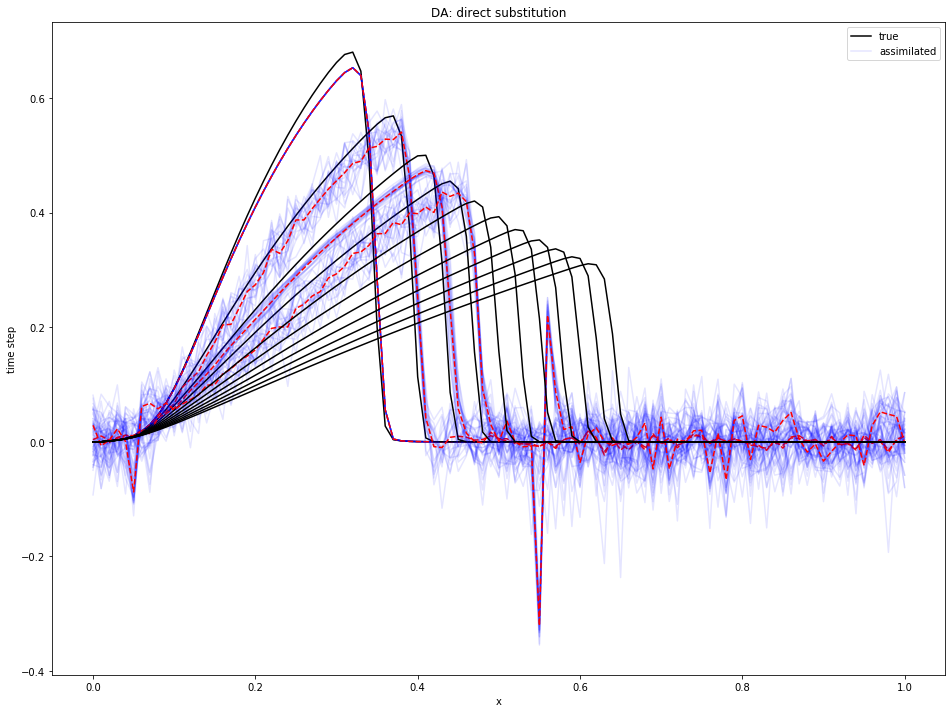

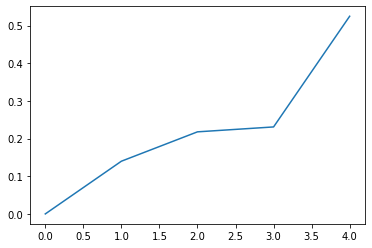

In [16]:
# initialization
error=1e-2
u=u_init.copy()+np.random.randn(u.shape[0])*error
fig=plt.figure(figsize=(16,12))
ax = fig.gca()

ass_int=m_steps   # assimilate every xxx steps

# generate particles
p_num=20
std=.001*np.eye(J)
R=.1

err_s=np.zeros(int(nt/n_out))

up=np.zeros((p_num,J))

for p_i in range(p_num):
    up[p_i,:]=u_init.copy()

weights=np.zeros(p_num)+1./p_num
for n in range(1,nt):
        
            
    for p_i in range(up.shape[0]):
        u=up[p_i,:]
        u[0]=u[J-2]
        u[1]=u[J-1]

        # forecast
        for i in range(1,J-1):
            u[i] =u[i] -a*deltat/deltax/2*(u[i]**2 -u[i-1]**2) 
        up[p_i,:]=u
        
        
        # assimilation step:
        if n%m_steps==0:
            # measure distance between the forecast and measurements
            dist=np.linalg.norm(u[::m_dist]-u_m[:,int(n/m_steps)])
            
            # calculate weights
            weights[p_i]=scipy.stats.norm(0, R).pdf(dist)

    if n%m_steps==0:
        weights /=np.sum(weights)   # normalize
        # resampling (Kitagawa method)
        indices=[0]*p_num
        cdf = np.zeros(p_num)
        for p_i in range(p_num):
            cdf[p_i] = np.sum(weights[:p_i+1])
#             plt.plot(up[p_i,:])
        urand = np.random.random()/p_num
        
        for i in range(p_num):
            indices[i] = np.searchsorted(cdf, urand)
            urand += 1./p_num
        up = up[indices,:]
        
        # re-perturb
        perturb=np.random.multivariate_normal(np.zeros_like(x), std, up.shape[0])
        for p_i in range(up.shape[0]):
            up[p_i,:]=up[p_i,:]+perturb[p_i,:]
#         dist1
#         plt.show()
#         dist1
    
    # plot
    if n%n_out==0:
        ue=np.average(up,axis=0)
        ax.plot(x,u_t[:,n],color='black')
        for p_i in range(p_num):
            ax.plot(x,up[p_i,:],color='blue',alpha=0.1)
        ax.plot(x,ue,'--',color='red')
        err_s[int(n/n_out)]=np.linalg.norm(u_t[:,n]-ue)
    
ax.set_xlabel('x')
ax.set_ylabel('time step')
ax.set_title('DA: direct substitution')
ax.legend(['true','assimilated'])
plt.show()

plt.plot(err_s)
plt.show()
